***Note***: These notebooks currently use deprecated versions of our Python SDK, as well as `PSOrthoTile`, an item-type that is no longer available. An updated version of these notebooks are currently in progress.

# DRC Roads - Find and Download Scenes

In this notebook we focus on a region in the Democratic Republic of Congo where roads have been built into the forest. In the area of interest (AOI) we are using, the roads were built between September and November 2017.

Because the AOI overlaps the PSScene images, but only covers a portion of each scene, this notebook demonstrates working with PSScene to identify significantly overlapping scenes and mosaicing multiple scenes on download. Additionally, this notebook demonstrates use of the planet python client to manage the download, and mosaicing of multiple scenes.

This notebook does the following:
- filter by overlap of a set of PSScene images to an AOI that straddles image grid boundaries
- take advantage of Clip Tool in the Orders Toolchain to download only the pixels within the AOI
- mosaic and crop images on download to a single strip scene that significantly overlaps AOI
- use the planet python client to activate, and mosaic multiple scenes across multiple PSScene strips

Keywords: mosaicing, search, download

In [1]:
from datetime import datetime
import json
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from planet import Auth, data_filter, order_request, reporting
from planet import Session
import rasterio
from shapely import geometry as sgeom
from shapely.ops import unary_union
import visual

## Define AOI

The AOI is a region in the Democratic Republic of Congo that experiences road development between September and November 2017. It is a rectangle that overlaps PSScene image boundaries.

In [2]:
aoi = {"geometry": {
    "type":"Polygon",
    "coordinates":
        [[
            [25.42429478260258,1.0255377823058893],
            [25.592960813580472,1.0255377823058893],
            [25.592960813580472,1.1196578801254304],
            [25.42429478260258,1.1196578801254304],
            [25.42429478260258,1.0255377823058893]
        ]]}}


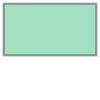

In [3]:
aoi_shape = sgeom.shape(aoi['geometry'])
aoi_shape

## Find PSScenes that Overlap AOI

### Build API Search Request

In [4]:
# if your Planet API Key is not set as an environment variable, you can paste it below
if 'PL_API_KEY' in os.environ:
    API_KEY = os.environ['PL_API_KEY']
else:
    API_KEY = 'PASTE_API_KEY_HERE'
    os.environ['PL_API_KEY'] = API_KEY

client = Auth.from_key(API_KEY)

In [79]:
# Build Search Request

item_types = ["PSScene"]

geom_filter = data_filter.geometry_filter(aoi)
date_range_filter = data_filter.date_range_filter("acquired", gt = datetime(month=9, day=1, year=2017), lt = datetime(month=12, day=1, year=2017))
cloud_cover_filter = data_filter.range_filter('cloud_cover', lte = 0.05) # Ratio of the area covered by clouds to that which is uncovered.

combined_filter = data_filter.and_filter([geom_filter, date_range_filter, cloud_cover_filter])

In [80]:
# First, let's look at the stats for the request we're trying to make
async with Session() as sess:
        cl = sess.client('data')
        stats = await cl.get_stats(search_filter=combined_filter, item_types=item_types, interval='month')

In [81]:
# Let's take a look at our stats
print(json.dumps(stats, indent =4))

{
    "buckets": [
        {
            "count": 26,
            "start_time": "2017-09-01T00:00:00.000000Z"
        },
        {
            "count": 12,
            "start_time": "2017-10-01T00:00:00.000000Z"
        },
        {
            "count": 13,
            "start_time": "2017-11-01T00:00:00.000000Z"
        }
    ],
    "interval": "month",
    "utc_offset": "+0h"
}


In [82]:
# Let's build our search request
async with Session() as sess:
        cl = sess.client('data')
        request = await cl.create_search(name='drc_roads', search_filter=combined_filter, item_types=item_types)

In [123]:
# Now we can run our search for those items
async def search_pl_api(request):
    async with Session() as sess:
            cl = sess.client('data')
            items = cl.run_search(request['id'])
            item_list = [i async for i in items]
    return item_list

item_list = await search_pl_api(request)

### Save scene data for further processing

In [124]:
def items_to_scenes(items):
    item_types = []

    def _get_props(item):
        props = item['properties']
        
        # add data not in properties list
        props.update({
            'thumbnail': item['_links']['thumbnail'],
            'id': item['id'],
            'footprint': item['geometry'],
        })
        return props
    
    scenes = pd.DataFrame(data=[_get_props(i) for i in items])
    
    # convert acquired from string to datetime for processing
    scenes['acquired'] = pd.to_datetime(scenes['acquired'])
    
    return scenes

scenes = items_to_scenes(item_list)
scenes.head()

,acquired,anomalous_pixels,cloud_cover,ground_control,gsd,instrument,item_type,pixel_resolution,provider,published,...,footprint,clear_confidence_percent,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent
0,2017-11-29 08:01:24.601511+00:00,0.0,0.04,True,3.9,PS2,PSScene,3,planetscope,2021-02-17T05:09:16Z,...,"{'coordinates': [[[25.50396158565228, 1.058973...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-27 08:01:52.190827+00:00,0.0,0.00,True,4.0,PS2,PSScene,3,planetscope,2021-02-17T04:07:58Z,...,"{'coordinates': [[[25.29413911363316, 1.221536...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-27 08:01:53.230819+00:00,0.0,0.00,True,4.0,PS2,PSScene,3,planetscope,2021-02-17T04:07:19Z,...,"{'coordinates': [[[25.281443642095812, 1.15511...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-27 08:01:54.270811+00:00,0.0,0.00,True,4.0,PS2,PSScene,3,planetscope,2021-02-17T04:07:04Z,...,"{'coordinates': [[[25.269428352539634, 1.08869...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-27 08:00:59.379316+00:00,0.0,0.01,True,4.0,PS2,PSScene,3,planetscope,2021-02-17T04:04:24Z,...,"{'coordinates': [[[25.548303619498004, 1.06512...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter to scenes with footprints that overlap AOI

When the API searches for a scene that overlaps a given AOI, it uses the scene extent. However, we are interested in the scene footprint. That is, we don't care if a portion of a scene with no data overlaps the AOI. We want to filter those scenes out.

In [85]:
def aoi_intersection(footprint, aoi):
    aoi_shape = sgeom.shape(aoi['geometry'])
    footprint_shape = sgeom.shape(footprint)
    intersection_shape = aoi_shape.intersection(footprint_shape)

    try:
        intersection_percent = 100 * footprint_shape.area / intersection_shape.area
    except ZeroDivisionError:
        intersection_percent = 0

    data = {'intersection_shape': intersection_shape,
            'intersection_fp_perc': intersection_percent}
    return pd.Series(data=data)

intersections = scenes.footprint.apply(aoi_intersection, args=(aoi,))

scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)

In [86]:
# filter out scenes with no intersection
scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
len(scenes_inter)

51

## Strip Overlap

Because the AOI straddles PSScene grid lines, we focus on the overlap between the AOI and the strip (which is what is cut into PSScenes).

We want to filter to strips that have a significant (80%) overlap

### Group scenes by strips

In [87]:
scenes_sid = scenes_inter.groupby(['strip_id'])
print('{} intersecting strips'.format(scenes_sid.ngroups))

23 intersecting strips


In [88]:
def get_date(group):
    dates = set([a.date() for a in group['acquired']])
    assert len(dates) == 1
    return min(dates)

strip_date = scenes_sid.apply(get_date)
strip_date.head()

strip_id
739002    2017-09-07
739199    2017-09-07
741219    2017-09-08
741529    2017-09-08
742426    2017-09-08
dtype: object

### Calculate strip overlap

In [89]:
def get_strip_aoi_inter(group, aoi):
    '''group: data frame with strip id as index'''
    intersections = group['intersection_shape'].tolist()
    intersection_shape = unary_union(intersections)
    aoi_shape = sgeom.shape(aoi['geometry'])

    try:
        intersection_percent = 100 * intersection_shape.area / aoi_shape.area
    except ZeroDivisionError:
        intersection_percent = 0 

    data = {'strip_intersection_shape': intersection_shape,
            'strip_intersection_aoi_perc': intersection_percent}
    return pd.Series(data=data)
    

# with help from: https://stackoverflow.com/a/43616001/2344416
strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=aoi)

strip_aoi_inter.head()

,strip_intersection_shape,strip_intersection_aoi_perc
strip_id,,
739002,"POLYGON ((25.5697190973412 1.0255377823058893,...",8.236497
739199,"POLYGON ((25.42429478260258 1.026886947546929,...",100.000000
741219,POLYGON ((25.49568045814796 1.0255377823058893...,52.231386
741529,POLYGON ((25.42429478260258 1.0255377823058893...,100.000000
742426,POLYGON ((25.569650352852015 1.119657880125430...,1.659954


array([[<AxesSubplot:title={'center':'strip_intersection_aoi_perc'}>]],
      dtype=object)

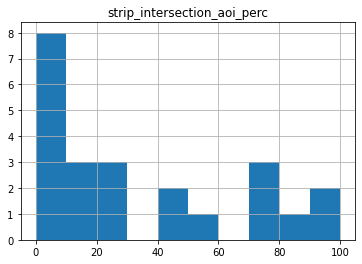

In [90]:
# what does the distribution of intersection percent of aoi look like?
strip_aoi_inter.hist(bins=10)

### Filter to strips that have significant overlap

Here we are defining significant overlap as an overlap of at least 80% of the AOI area.

In [91]:
# add acquisition date information before filtering
strips = strip_aoi_inter.assign(acquisition_date=strip_date)

In [92]:
# filter to strips that have significant overlap
strips_filt = strips[strips.strip_intersection_aoi_perc > 80]
print('{} images with significant overlap'.format(len(strips_filt)))

3 images with significant overlap


In [93]:
# what are the collection dates of strips with significant overlap?
strips_filt.acquisition_date

strip_id
739199    2017-09-07
741529    2017-09-08
943459    2017-11-26
Name: acquisition_date, dtype: object

There are 3 significantly overlapping strips in September, just 1 in October, and 5 in November. Now let's move on to filtering the scene list to scenes in those strips.

### Filter to scenes in strips that have significant overlap

In [94]:
overlapping_strip_ids = strips_filt.index.tolist()
overlapping_strip_ids

['739199', '741529', '943459']

In [95]:
# filter to scenes that are in the resulting strips
overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]

In [96]:
print('There are {} PSScene images in {} strips that significantly overlap the AOI.'.format(
    len(overlapping_scenes), len(overlapping_strip_ids)))

There are 9 PSScene images in 3 strips that significantly overlap the AOI.


In [97]:
# save overlapping scenes dataframe for use in other notebooks
# uncomment to save
# overlapping_scenes_filename = os.path.join('pre-data', 'overlapping-scenes')
# overlapping_scenes.to_pickle(overlapping_scenes_filename)

### Create download function

Combine all of the steps above into one function call.

In [98]:
async def get_overlapping_scenes(request, overlap_perc=80):
    # get all scenes with overlapping bounds
    items = await search_pl_api(request)
    scenes = items_to_scenes(items)
    print('{} scenes with intersecting borders'.format(len(scenes)))
    
    # filter to scenes where the footprint overlaps
    intersections = scenes.footprint.apply(aoi_intersection, args=(aoi,))
    scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)
    scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
    print('{} scenes with intersecting footprints'.format(len(scenes_inter)))
    
    # filter to strips with significant overlap
    scenes_sid = scenes_inter.groupby(['strip_id'])
    strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=aoi)
    print('{} intersecting strips'.format(scenes_sid.ngroups))
    
    strip_date = scenes_sid.apply(get_date)
    strips = strip_aoi_inter.assign(acquisition_date=strip_date)
    strips_filt = strips[strips.strip_intersection_aoi_perc > overlap_perc]
    print('{} strips with significant overlap'.format(len(strips_filt)))
    
    # filter to scenes that are in resulting strips
    overlapping_strip_ids = strips_filt.index.tolist()
    overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]
    
    print('There are {} PSScene images in {} strips that significantly overlap the aoi'.format(
    len(overlapping_scenes), len(overlapping_strip_ids)))
    return overlapping_scenes

# run again with the same inputs to make sure we get the same results
_ = await get_overlapping_scenes(request)

51 scenes with intersecting borders
51 scenes with intersecting footprints
23 intersecting strips
3 strips with significant overlap
There are 9 PSScene images in 3 strips that significantly overlap the aoi


## Download and Mosaic Strip PSScene COGs

Because the AOI crosses over PSScene grid lines, we need multiple images from one strip to obtain the image that overlaps the AOI. But the portion of each PSScene image that overlaps the AOI is small relative to the orthotile. Therefore, we only want to download the pixels in the orthotile that overlap the AOI. We will accomplish this by accessing the PSScene images as Cloud-Optimized Geotiffs (COGs).

This is a variation of the COG activation and download performed in `temporal-analysis/crop-temporal.ipynb`. For this notebook, we wait until all orthotiles in a strip are activated then we download the COGs together, using `gdalwarp` to perform the download as well as the mosaicing.

First, we will go through this exercise with one strip, then we will move onto multiple strips.

### Define asset type

For this application, we are interested in the analytic product. This is top-of-atmosphere radiance.

In [99]:
asset_type = 'ortho_analytic_4b'

### Get scenes that compose a strip

Next we need all the ids for scenes that compose a strip.

In [100]:
strip_id = overlapping_strip_ids[0]
print(strip_id)

strip_scenes = scenes[scenes['strip_id'] == strip_id]
strip_scenes

739199


,acquired,anomalous_pixels,cloud_cover,ground_control,gsd,instrument,item_type,pixel_resolution,provider,published,...,footprint,clear_confidence_percent,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent
48,2017-09-07 07:58:16.965240+00:00,0.01,0.02,True,3.9,PS2,PSScene,3,planetscope,2021-02-14T20:50:06Z,...,"{'coordinates': [[[25.39979949187616, 1.031756...",92.0,98.0,2.0,0.0,0.0,1.0,0.0,79.0,98.0
49,2017-09-07 07:58:15.930246+00:00,0.01,0.00,True,3.9,PS2,PSScene,3,planetscope,2021-02-14T20:50:06Z,...,"{'coordinates': [[[25.41247974542781, 1.096963...",93.0,100.0,0.0,0.0,0.0,0.0,0.0,74.0,100.0
50,2017-09-07 07:58:14.895252+00:00,0.01,0.00,True,3.9,PS2,PSScene,3,planetscope,2021-02-14T20:49:59Z,...,"{'coordinates': [[[25.425548475652743, 1.16265...",93.0,100.0,0.0,0.0,0.0,0.0,0.0,79.0,100.0


In [101]:
strip_scenes['id'].tolist()

['20170907_075816_0f43', '20170907_075815_0f43', '20170907_075814_0f43']

### Activate Scenes

We use the planet api client [downloader](https://planetlabs.github.io/planet-client-python/api/reference.html#planet.api.downloader.Downloader) to handle activation of the scenes. The downloader handles activation, polling activation status, and (if desired), downloading. Because we are using remote COGs, we do not want to download the scene. However, the downloader can still help us out. It has a cool feature where you can provide it with a function to call when a scene is activated.

In this section, we will provide it with a function that records the scene id and download url and checks to see if all scenes in the strip are activated. The function is actually just a method of a class (`Tracker`), which maintains a dataset of scene ids and download urls and a list of scene ids in the strip. The method updates the scene id list when it is called by the downloader. Also, it checks to see if all scenes in the strip have been activated. In the future, we will update this part so that when all scenes in a strip are activated, a download and mosaic is triggered.

In [102]:
# only download the aoi portion of the COGs and mosaic them in one step

Here, we are ordering the `analytic_sr_udm2` bundle, as it contains the `ortho_analytic_4b` that we are interested in. 

To find out more about bundles, see our [Scenes Product Bundles Reference](https://developers.planet.com/apis/orders/product-bundles-reference/) page.

In [103]:
item_ids = strip_scenes['id'].tolist()

products = [order_request.product(item_ids=item_ids, product_bundle='analytic_sr_udm2', item_type='PSScene')]

tools = [order_request.composite_tool(), order_request.file_format_tool(file_format="COG"), order_request.clip_tool(aoi)]

order_request = order_request.build_request('drc_roads_download', products=products, tools=tools)

In [104]:
order_request

{'name': 'drc_roads_download',
 'products': [{'item_ids': ['20170907_075816_0f43',
    '20170907_075815_0f43',
    '20170907_075814_0f43'],
   'item_type': 'PSScene',
   'product_bundle': 'analytic_sr_udm2'}],
 'tools': [{'composite': {}},
  {'file_format': {'format': 'COG'}},
  {'clip': {'aoi': {'type': 'Polygon',
     'coordinates': [[[25.42429478260258, 1.0255377823058893],
       [25.592960813580472, 1.0255377823058893],
       [25.592960813580472, 1.1196578801254304],
       [25.42429478260258, 1.1196578801254304],
       [25.42429478260258, 1.0255377823058893]]]}}}]}

In [105]:
# remember: "async def" to create the async coroutine
async def create_poll_and_download():
    async with Session(auth=client) as sess:
        cl = sess.client('orders')

        # Use "reporting" to manage polling for order status
        with reporting.StateBar(state='creating') as bar:
            
            # create order via Orders Client
            order = await cl.create_order(order_request)
            bar.update(state='created', order_id=order['id'])

            # Wait for our order to complete
            await cl.wait(order['id'], callback=bar.update_state)

        # if we get here that means the order completed. Yay! Download the files.
        print("Downloading Order...")
        order = await cl.download_order(order['id'])
        print("Order Downloaded")
        return order

# remember: "await" to run our function
# This may take several minutes
order = await create_poll_and_download()

42:22 - order 7ca3d8dc-c618-49a7-bfd4-05d378963487 - state: success


Order Downloaded


In [106]:
order

[PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075815_0f43_metadata.json'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/composite_udm2.tif'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075816_0f43_metadata.json'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/composite_file_format.tif'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075814_0f43_3B_AnalyticMS_metadata_clip.xml'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075815_0f43_3B_AnalyticMS_metadata_clip.xml'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/composite_metadata.json'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075814_0f43_metadata.json'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/20170907_075816_0f43_3B_AnalyticMS_metadata_clip.xml'),
 PosixPath('7ca3d8dc-c618-49a7-bfd4-05d378963487/manifest.json')]

In [107]:
file = [path for path in order if 'composite_file_format' in path.name][0]

### Download and mosaic strip scenes

Ok! All scenes in the strip are activated. Now it's time to download them. We are using `gdalwarp` to download the scenes, and it turns out `gdalwarp` is also used for mosaicing scenes, so we are going to download and mosaic the scenes all in one step.

### Save aoi as geojson file

`gdalwarp` requires the aoi used to crop the COG be saved to disk. We want the AOI to persist in git for use elsewhere so we save it in the `pre-data` folder.

In [108]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

In [109]:
def save_geojson_file(aoi_geojson, save_dir):
    filename = os.path.join(save_dir, 'aoi.geojson')
    with open(filename, "w") as f:
        f.write(json.dumps(aoi_geojson))
    return filename

geojson_filename = save_geojson_file(aoi, create_save_dir('pre-data'))
print('wrote AOI to {}'.format(geojson_filename))

wrote AOI to pre-data/aoi.geojson


## Visualize Strip Mosaic Image

In [110]:
# load local visual module
import visual

7ca3d8dc-c618-49a7-bfd4-05d378963487/composite_file_format.tif


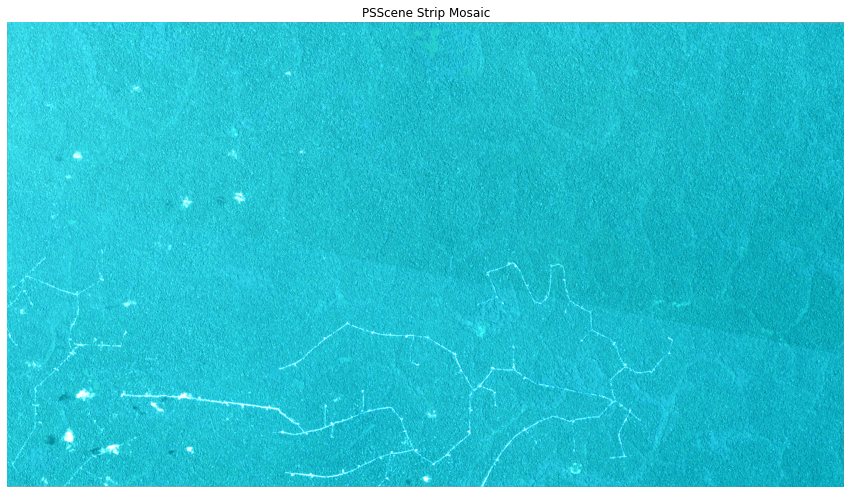

In [111]:
def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # visual band ordering: red, green, blue, alpha
        r, g, b, n = src.read() 

        # NoData value is 0
        mask = b == 0

    return [np.ma.array(band, mask=mask) for band in [r, g, b, n]]

def visualize_4band(bgrn_bands, title='PSScene Strip Mosaic', figdim=15):
    rgb_bands = [bgrn_bands[i] for i in [0, 1, 2]]
    visual.plot_image(rgb_bands, title=title, figsize=(figdim, figdim))

print(file)
visualize_4band(load_4band(file))

What a beautiful image! It is blue due to atmospheric effects. There are a few clouds, but we can clearly see roads in the forest.

TODO: Incorporate UDM filter into analysis (does it help?)